#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 10
**CH10A Understanding the gender difference in earnings**

using the cps-earnings dataset

version 1.0 2021-05-05 (modified 16.11.2023)

## Recap theory

**Multiple linear regression**: start with two explanatory variables

$y^E = \beta_0 + \beta_1x_1 + \beta_2x_2$

Interpretation (all variables are in *level*):
- $\beta_0$: average $y$ for observations if both $x_1$ and $x_2$ are zero in the data

- $\beta_1$: $y$ is, on average, $\beta_1$ units larger in the data for observations with one unit larger $x_1$, keeping $x_2$ constant

- $\beta_2$: $y$ is, on average, $\beta_2$ units larger in the data for observations with one unit larger $x_2$, keeping $x_1$ constant

**Omitted variable bias**

-> compare the difference in slope coefficient on $x_1$ when it is the only explanatory variable vs when also $x_2$ is included
- $y^E=\alpha+\beta x_1$ (compare observations that are different in $x_1$)
- $y^E=\beta_0+\beta_1 x_1 +\beta_2x_2$ (compare observations that are different in $x_1$ but similar in $x_2$ -> difference in $y$ by $x_1$, conditional on/controlling for $x_2$) 

-> are $x_1$ and $x_2$ related?
- $x^E_2=\gamma + \delta x_1$

> with $\delta\ne0$ ($x_1$ and $x_2$ are correlated)

> $\delta>0$: observations with higher $x_2$ tend to have higher $x_1$

-> plug the x-x reg in
$y^E=\beta_0+\beta_1 x_1 +\beta_2x_2=\beta_0+\beta_1 x_1 +\beta_2(\gamma + \delta x_1)=\beta_0+\beta_1 x_1 +\beta_2\gamma + \beta_2\delta x_1$

- the slope coefficients on $x_1$ with and without $x_2$ are different -> **omitted variable bias** $\beta-\beta_1=\delta\beta_2$ if

> $\delta\ne0$ or $\beta_2\ne0$

> the sign of the bias depends on both $\delta$ and $\beta_2$


## Case Study


Gender wage gap: understand what is potentially associated with gender differences in earnings

In [12]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

warnings.filterwarnings("ignore")


In [13]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("TAsessions")[0]

# location folders
data_in = dirname + "TAsessions/da_data_repo/cps-earnings/clean/"
data_out = dirname + "TAsessions/ch10-gender-earnings-understand/"
output = dirname + "TAsessions/ch10-gender-earnings-understand/output/"
func = dirname + "TAsessions/ch00-tech-prep/"
sys.path.append(func)


In [14]:
# Import the prewritten helper functions
from py_helper_functions import *


In [15]:
cps = pd.read_csv(data_in + "morg-2014-emp.csv")


CPS 2014: representative sample of all people age 15-85 in USA in 2014

We want to focus on all employees with a graduate degree (more than 4-year college degree -> professional, master's and doctoral degree)

Select people aged 24-65; exclude those who reported >=20 hours weekly time worked and those with nonpositive reported earnings

In [16]:
cps = cps.query("uhours>=20 & earnwke>0 & age>=24 & age<=64 & grade92>=44")


In [17]:
# CREATE VARIABLES
cps["female"] = (cps.sex == 2).astype(int) #dummy
cps["w"] = cps["earnwke"] / cps["uhours"] #hourly wages
cps["lnw"] = np.log(cps["w"]) #log hourly wages
## Write out to csv
cps.to_csv(data_out + "earnings_multireg.csv")


In [18]:
#####################
# DISTRIBUTION OF EARNINGS
#######################
cps.loc[:, ["earnwke", "uhours", "w"]].describe()


,earnwke,uhours,w
count,18241.00000,18241.000000,18241.000000
mean,1481.78936,42.970780,34.525791
std,747.92426,9.139368,16.654215
min,0.01000,20.000000,0.000200
25%,923.00000,40.000000,21.634500
50%,1346.00000,40.000000,31.250000
75%,1923.07000,47.000000,45.673000
max,2884.61000,99.000000,144.230500


In [19]:
#cps.loc[cps.w >= 1, ["earnwke", "uhours", "w"]].describe()


## Log earnings - age and gender

### Table 10.1 Gender differences in earnings – log earnings and gender

In [20]:
# use robust std
reg = smf.ols(formula="lnw~female", data=cps).fit(cov_type="HC1")
reg2 = smf.ols(formula="lnw~female+age", data=cps).fit(cov_type="HC1")
reg3 = smf.ols(formula="age~female", data=cps).fit(cov_type="HC1")


In [21]:
stargazer = Stargazer([reg, reg2, reg3])
stargazer.custom_columns(["ln wage", "ln wage", "age"], [1, 1, 1])
stargazer.covariate_order(["female", "age", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer


- (1) $\ln(w)=\alpha + \beta female + \varepsilon$:
> in this sample, women are expected to earn 19.5 log points [ $(\exp^{0.195} - 1)*100% = 21%$ ] less than men, on average
- (2) $\ln(w)=\beta_0 + \beta_1 female + \beta_2 age + e$: 
> comparing employees of the same age, women are expected to earn around 20% (18.5 log points) less than men in this sample, on average; 1 year older employees are expected to earn 0.7% more on average, other things equal
- (3) $female = \gamma + \delta age$: 
> women are younger, on average, in this data -> women have disadvantage in the data, since younger people are expected to earn less 

-> when we add *age* to the regression (2), the estimated coefficient on *female* appears to be lower 
> **omitted variable bias**: $\beta -\beta_1=-0.195 - (-0.185) = -0.01$ -> the difference is equal to $\delta\beta_2=-1.48\times 0.007 \sim -0.01$

-> 1% of 19.5% -> 5% of the difference in earnings is explained by younger

### Inference
Simple SE formula for $y^E=\beta_0 + \beta_1x_1 + \beta_2x_2$: 

$SE(\hat{\beta}_1) = \frac{Std[e]}{\sqrt{n}Std(x_1)\sqrt{1-R^2_1}}$
> in robust formula denominator $\sqrt{n-k-1}$
- $e=y-\hat{\beta}_0 + \hat{\beta}_1x_1 + \hat{\beta}_2x_2$
- $R^2_1$ is the R-squared in the regression $x_1$ on $x_2$

$SE(\hat{\beta}_1)\downarrow$ if
- $Std(e)\downarrow$
- $n\uparrow$
- $Std(x_1)\uparrow$
- $R^2_1\downarrow$ (smaller correlation between $x_1$ and $x_2$)

>$|R^2_1|=1$ -> $SE(\hat{\beta}_1)$ does not exist and coefficients cannot be computed -> **perfect collinearity**

>high $|R^2_1|$ -> high $SE(\hat{\beta}_1)$ -> **multicollinearity**

**Joint significance** of all coefficients: look at **global F-test** and reject the null (all coefficients are equal to 0) if p-value < significance level

Back to the case study - **Inference**: 

-> coefficients are statistically significant at 1% level

-> look at CIs and F-tests

In [22]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     531.5
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          5.96e-116
Time:                        12:10:50   Log-Likelihood:                -15672.
No. Observations:               18241   AIC:                         3.135e+04
Df Residuals:                   18239   BIC:                         3.136e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5145      0.006    573.388      0.000       3.502       3.526
female        -0.1953      0.008    -23.055      0.000      -0.212      -0.179
==============================================================================
Omnibus:                    15252.403   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1835979.169
Skew:                          -3.402   Prob(JB):                         0.00
Kurtosis:                      51.676   Cond. No.                         2.70
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [23]:
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     447.3
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          2.20e-190
Time:                        12:10:52   Log-Likelihood:                -15509.
No. Observations:               18241   AIC:                         3.102e+04
Df Residuals:                   18238   BIC:                         3.105e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1978      0.018    176.797      0.000       3.162       3.233
female        -0.1847      0.008    -21.937      0.000      -0.201      -0.168
age            0.0071      0.000     18.308      0.000       0.006       0.008
==============================================================================
Omnibus:                    15618.290   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2007068.681
Skew:                          -3.521   Prob(JB):                         0.00
Kurtosis:                      53.903   Cond. No.                         201.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

- The **95% CIs** on female coefficients **overlap** -> it is possible that there are no differences between these coefficients in the population

- **F-test**: reject the null in all 3 regressions

**Age distribution**: look at age distribution separately for males and females

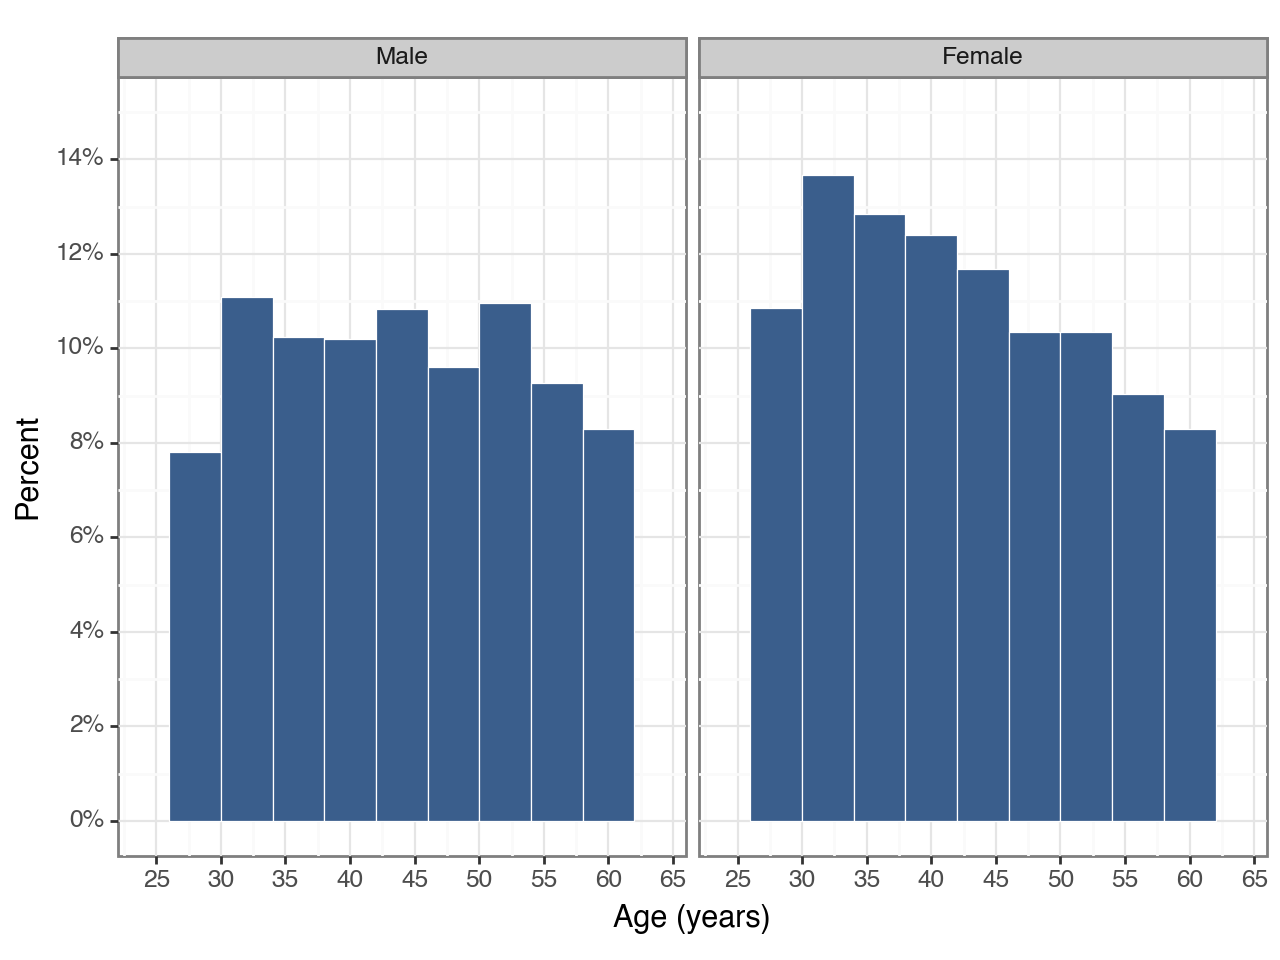

<Figure Size: (640 x 480)>

In [24]:
(
    ggplot(cps, aes(x="age", y="2*stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=4,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Age (years)", y="Percent")
    + facet_wrap("~female", labeller={"0": "Male", "1": "Female"})
    + labs(x="Age (years)", y="Percent")
    + scale_x_continuous(
        limits=(24, 64),
        breaks=seq(25, 65, by=5),
    )
    + scale_y_continuous(
        limits=(0, 0.15), breaks=seq(0, 0.15, by=0.02), labels=percent_format()
    )
    + theme_bw()
)
#multiply y by 2 to see better

**Density plots**: Kernel density estimates of age distribution of employees with a graduate degree separately for female and male

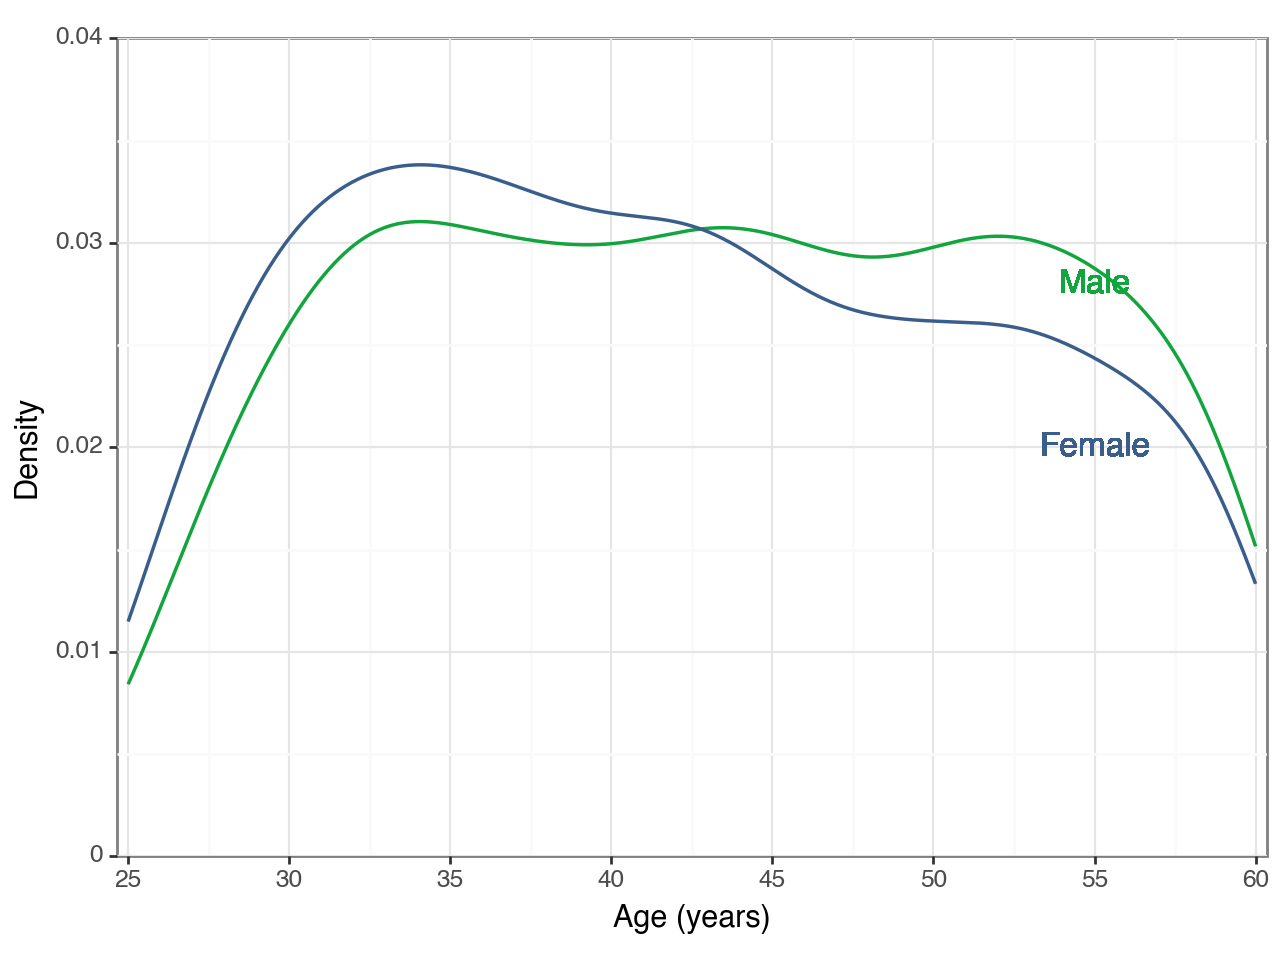

<Figure Size: (640 x 480)>

In [25]:
(
    ggplot(cps, aes(x="age", y="stat(density)", color="factor(female)"))
    + geom_density(adjust=1.5, show_legend=False, na_rm=True, size=0.7)
    + labs(x="Age (years)", y="Density", color="")
    + scale_color_manual(
        name="", values=(color[1], color[0]), labels=("Male", "Female")
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(25, 60), breaks=seq(25, 60, by=5))
    + scale_y_continuous(
        expand=(0.0, 0.0), limits=(0, 0.04), breaks=seq(0, 0.04, by=0.01)
    )
    + geom_text(aes(x=55, y=0.028, label="'Male'"), color=color[1], size=12)
    + geom_text(aes(x=55, y=0.020, label="'Female'"), color=color[0], size=12)
    + theme_bw()
)


- Few below age 30
- $>30$ close to uniform to men
- $>30$ drop above 45 and above 55

-> why? 
- fewer graduates $>45$ or
- fewer employeed (for more than 20h) $>45$

[further investigation: women are less likely to have graduate degree if born before 1970]

**Conclusions**

- we found a difference in the data between unconditional gender wage gap and gender gap conditional on age
- this difference is small
- it may not exist in the population

If more than 2 explanatory variables:

$y^E = \beta_0 + \beta_1x_1 +\beta_2x_2 + \beta_3x_3 + \dots$

-> on average, $y$ is $\beta_k$ units larger in the data for observations with one unit larger $x_k$, but with the same value for all other $x$ variables

-> $SE(\hat{\beta}_k) = \frac{Std[e]}{\sqrt{n}Std[x_k]\sqrt{1-R^2_k}}$

## Nonlinear pattern log earnings - age

### Table 10.2 Gender differences in earnings – log earnings and age, various functional forms

Remember in Ch09 we saw nonlinear relation log earnings and age:
- average log earnings are positive and steep function of age for younger people, then flatter pattern middle-aged, completely flat or even negative for older employees

Include squared, cubic and power 4

-> investigate gender wage gap conditional on age

In [26]:
cps["agesq"] = np.power(cps["age"], 2)
cps["agecu"] = np.power(cps["age"], 3)
cps["agequ"] = np.power(cps["age"], 4)


In [27]:
reg4 = smf.ols(formula="lnw~female", data=cps).fit(cov_type="HC1") #unconditional
reg5 = smf.ols(formula="lnw~female+age", data=cps).fit(cov_type="HC1") #age enters linearly
reg6 = smf.ols(formula="lnw~female+age+agesq", data=cps).fit(cov_type="HC1") #add quadratic
reg7 = smf.ols(formula="lnw~female+age+agesq+agecu+agequ", data=cps).fit(cov_type="HC1") #4-th order polynomial


In [28]:
stargazer = Stargazer([reg4, reg5, reg6, reg7])
stargazer.covariate_order(["female", "age", "agesq", "agecu", "agequ", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer


- estimates of conditional difference are close to each other and within each others' CIs

> the functional form for age does not really matter if we are interested in the average gender gap

- coefficient estimates of higher order polynomials are statistically significant

> nonlinear pattern is very likely true in the population

- Adjusted $R^2$ goes up for the more complicated specifications 

> it matters if goal is prediction, not for uncovering the average gender difference in earnings

## Include categories of education

### Table 10.3 Gender differences in earnings – log earnings, gender and education

Master, professional, PhD

In [29]:
cps["ed_MA"] = (cps["grade92"] == 44).astype(int)
cps["ed_Profess"] = (cps["grade92"] == 45).astype(int)
cps["ed_Phd"] = (cps["grade92"] == 46).astype(int)


Remember to include $k-1$ dummies 

-> the category not represented is the **reference category**

-> coefficients on each $k-1$ dummy show average differences in $y$ compared to the reference category

In [30]:
reg8 = smf.ols(formula="lnw~female", data=cps).fit(cov_type="HC1")
reg9 = smf.ols(formula="lnw~female + ed_Profess + ed_Phd", data=cps).fit(cov_type="HC1")
reg10 = smf.ols(formula="lnw~female + ed_Profess + ed_MA", data=cps).fit(cov_type="HC1")


In [31]:
stargazer = Stargazer([reg8, reg9, reg10])
stargazer.covariate_order(["female", "ed_Profess", "ed_Phd", "ed_MA", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer


- (1) $\ln(w)=\alpha + \beta female + \varepsilon$
- (2) $\ln(w)=\beta_0 + \beta_1 female + \beta_2 ed\_Profess + \beta_3 ed\_PhD + e$:
> [MA degree is the comparison group] comparing employees of the same age, those with professional degree are expected to earn on average 13.4% more than employees with an MA degree; those with PhD degree 13.6% more than employees with MA degree
- (3) $\ln(w)=\gamma_0 + \gamma_1 female + \gamma_2 ed\_Profess + \gamma_3 ed\_MA + u$: 
> [PhD degree is the comparison group] comparing employees of the same age, those with MA are expected to earn on average 13.6% less than employees with an PhD degree

> estimated coefficient on *female* is smaller (-0.182) when education is included
-> in the data, women appear to be more likely to be in lower-earner MA than in higher-earner professional or PhD - but only small part

## Interactions

$y^E=\beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_1x_2$ 

- (level-level variables)

> $\beta_1$: average differences in $y$ associated to one-unit difference in $x_1$ when $x_2=0$

> $\beta_2$: average differences in $y$ associated to one-unit difference in $x_2$ when $x_1=0$

> $\beta_3$: additional average differences in $y$ associated to one-unit difference in $x_1$ when $x_2$ is one unit larger too

- $x_2$ is a dummy

> $\beta_1$: average difference in $y$ associated to a one-unit difference in $x_1$ when $x_2=0$

> $\beta_1 + \beta_3$: average difference in $y$ associated to a one-unit difference in $x_1$ when $x_2=1$

>> if $x_2=0$: $y^E=\beta_0+\beta_1x_1$

>> if $x_2=1$: $y^E=(\beta_0+\beta_2)+(\beta_1+\beta_3)x_1$

### Table 10.4 Gender differences in earnings – log earnings, gender, age, and their interaction

Are patterns with age similar or different for men vs women?
- Regress separately for men and women
- Include interaction $age*gender$

$(\ln{w})^E = \beta_0 + \beta_1\times age +\beta_2\times female + \beta_3\times age \times female$

In [32]:
reg11 = smf.ols(formula="lnw~age", data=cps.query("female==1")).fit(cov_type="HC1")
reg12 = smf.ols(formula="lnw~age", data=cps.query("female==0")).fit(cov_type="HC1")
reg13 = smf.ols(formula="lnw~female+age+age*female", data=cps).fit(cov_type="HC1")


In [33]:
stargazer = Stargazer([reg11, reg12, reg13])
stargazer.covariate_order(["female", "age", "age:female", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant", "age:female": "female x age"})
stargazer.custom_columns(["Women", "Men", "All"], [1, 1, 1])
stargazer


- (1): women who are one year older are expected to earn 0.6% more, on average
- (2): men who are one year older are expected to earn 0.9% more, on average
- (3): slope of log earnings - age pattern is 0.003 less positive for women, on average  -> can do **inference** about gender differences

> women at age 25 -> predicted log wage $= 3.081 + 25\times 0.006 \sim 3.231$

> men at age 25 -> predicted log wage $= 3.117 + 25\times 0.009 \sim 3.342$

> difference $-0.11 \sim -0.036 + 25\times(-0.003)$

*Exercise*: calculate the difference when age=45 and compare it to -0.11

### Figure 10.2 Earning differences by gender as function of age
(A): $(\ln{w})^E = \beta_0 + \beta_1\times age +\beta_2\times female + \beta_3\times age \times female$

In [36]:
# PREDICTION AND GRAPH LINEAR
data_m = cps.query("female==0")

pred = reg13.predict(data_m)

pred = reg13.get_prediction(data_m).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_m = data_m.reset_index(drop=True).join(pred)

data_m["CIup"] = data_m["fit"] + 2 * data_m["fit_se"]
data_m["CIlo"] = data_m["fit"] - 2 * data_m["fit_se"]


In [37]:
data_f = cps.query("female==1")

pred = reg13.predict(data_f)

pred = reg13.get_prediction(data_f).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_f = data_f.reset_index(drop=True).join(pred)

data_f["CIup"] = data_f["fit"] + 2 * data_f["fit_se"]
data_f["CIlo"] = data_f["fit"] - 2 * data_f["fit_se"]


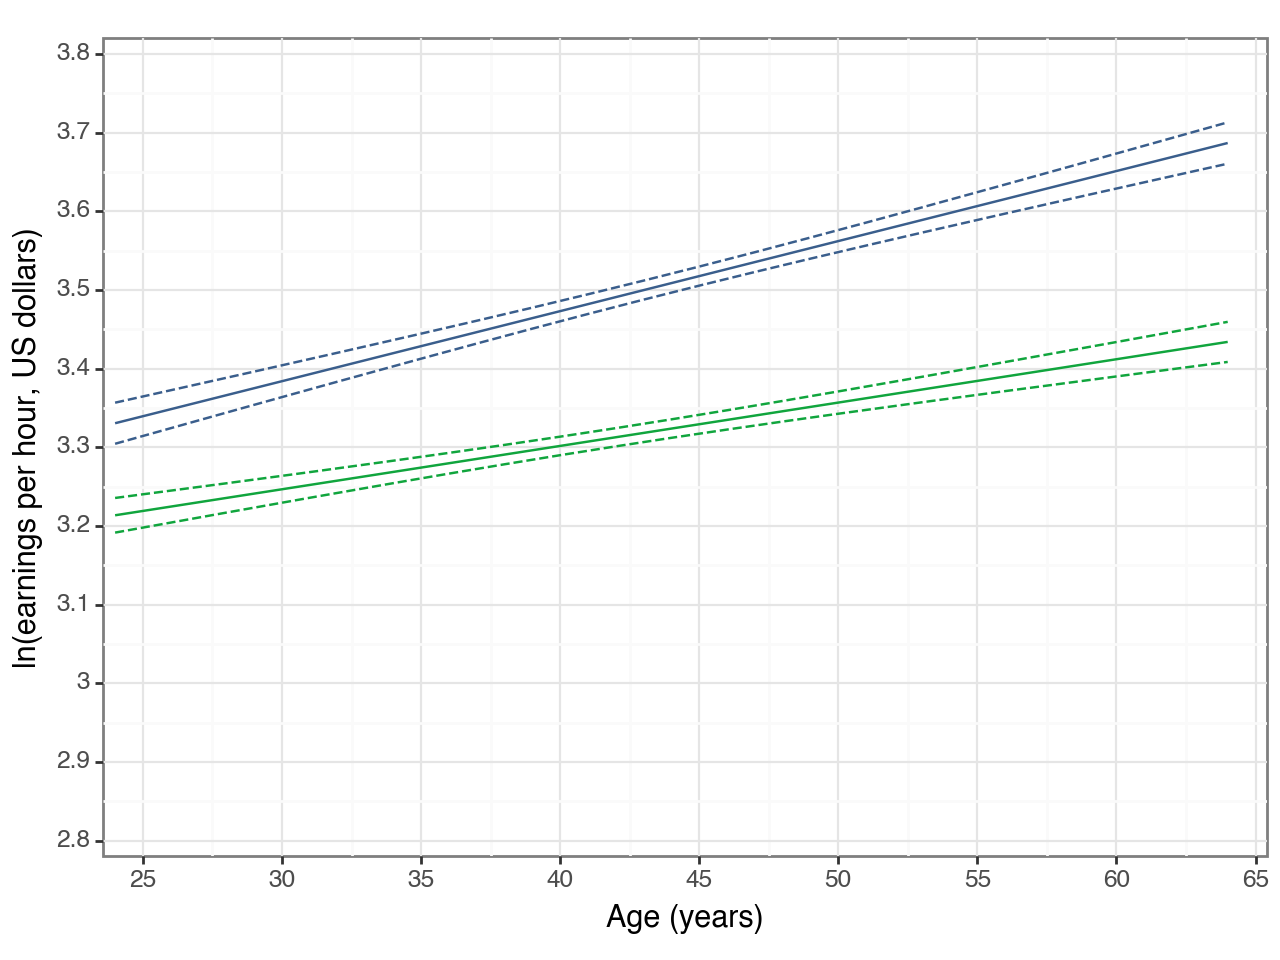

<Figure Size: (640 x 480)>

In [38]:
(
    ggplot(data_m, aes(x="age", y="fit"))
    + geom_line(colour=color[0])
    + geom_line(data_m, aes(x="age", y="CIup"), colour=color[0], linetype="dashed")
    + geom_line(data_m, aes(x="age", y="CIlo"), colour=color[0], linetype="dashed")
    + geom_line(data_f, aes(x="age", y="fit"), colour=color[1])
    + geom_line(data_f, aes(x="age", y="CIup"), colour=color[1], linetype="dashed")
    + geom_line(data_f, aes(x="age", y="CIlo"), colour=color[1], linetype="dashed")
    + labs(x="Age (years)", y="ln(earnings per hour, US dollars)")
    + scale_x_continuous(expand=(0.01, 0.01), limits=(24, 65), breaks=seq(25, 65, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.8, 3.8), breaks=seq(2.8, 3.8, by=0.1)
    )
    + theme_bw()
)

Including the interaction $female\times age$ enables us to see that the earnings difference appears to be higher for older age

-> growing gap 

Without interaction -> two parallel lines would be at constant distance

### Gender differences in earnings – log earnings, gender, 4th-order polynomial of age, and their interaction

In [39]:
reg14 = smf.ols(formula="lnw~age+agesq+agecu+agequ", data=cps.query("female==1")).fit(
    cov_type="HC1"
) #women
reg15 = smf.ols(formula="lnw~age+agesq+agecu+agequ", data=cps.query("female==0")).fit(
    cov_type="HC1"
) #men
reg16 = smf.ols(
    formula="lnw ~ age + agesq + agecu + agequ + female + female*age + female*agesq + female*agecu + female*agequ",
    data=cps,
).fit(cov_type="HC1")
 # interactions

In [40]:
Stargazer([reg14, reg15, reg16])


Fig 10.2 B) $(ln{w})^E = \beta_0 + \beta_1 age + \beta_2age^2+\beta_3age^3+\beta_4age^4+\beta_5female + \beta_6female\times age + \beta_7female\times age^2 + \beta_8female\times age^3 + \beta_9 female\times age^4$

In [41]:
# PREDICTION AND GRAPH POLYNOMIAL
# male
data_m = cps.query("female==0")

pred = reg16.predict(data_m)

pred = reg16.get_prediction(data_m).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_m = data_m.reset_index(drop=True).join(pred)

data_m["CIup"] = data_m["fit"] + 2 * data_m["fit_se"]
data_m["CIlo"] = data_m["fit"] - 2 * data_m["fit_se"]

# female
data_f = cps.query("female==1")

pred = reg16.predict(data_f)

pred = reg16.get_prediction(data_f).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_f = data_f.reset_index(drop=True).join(pred)

data_f["CIup"] = data_f["fit"] + 2 * data_f["fit_se"]
data_f["CIlo"] = data_f["fit"] - 2 * data_f["fit_se"]


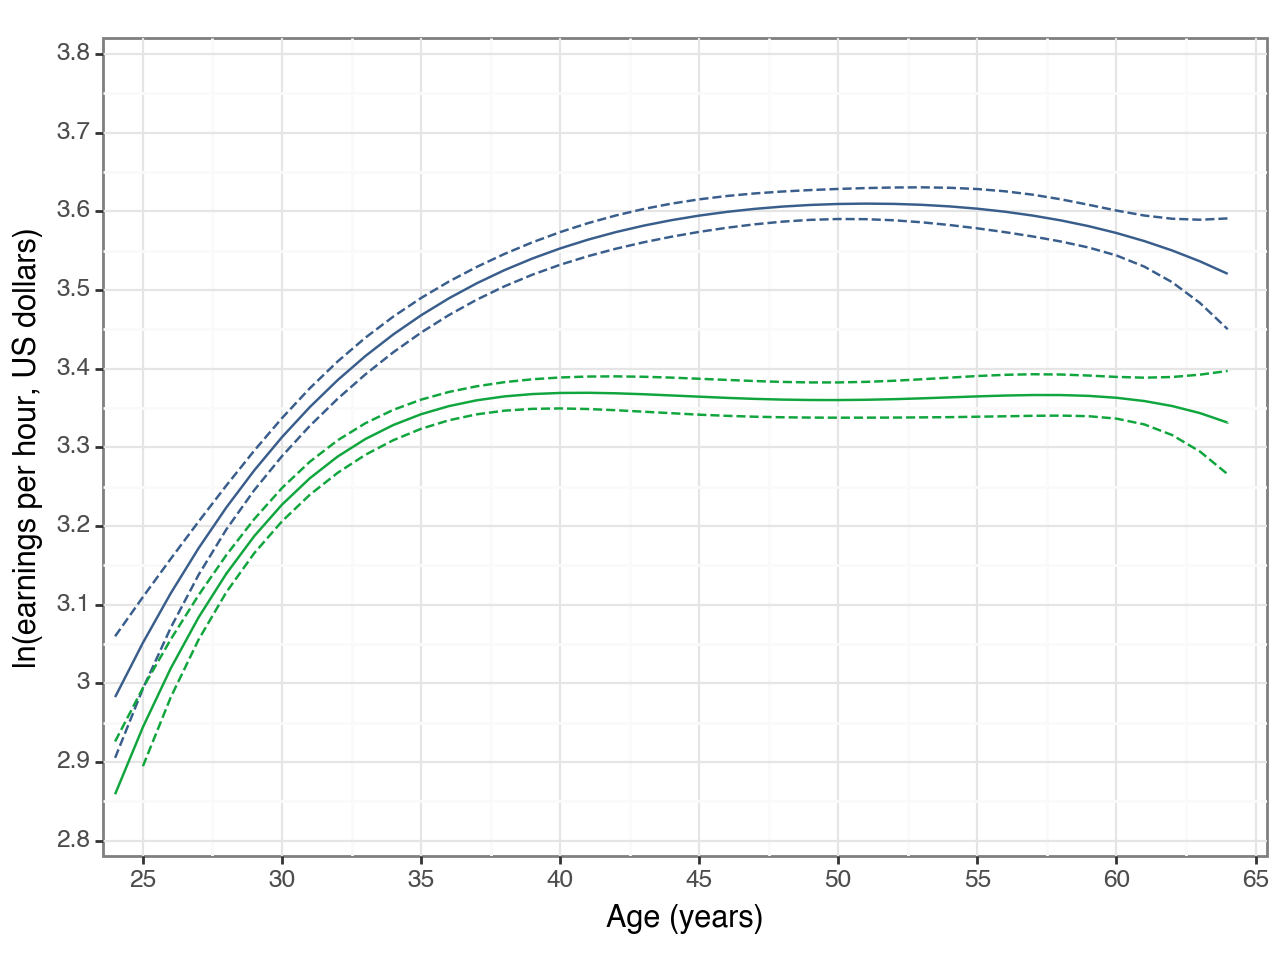

<Figure Size: (640 x 480)>

In [42]:
(
    ggplot(data_m, aes(x="age", y="fit"))
    + geom_line(colour=color[0])
    + geom_line(data_m, aes(x="age", y="CIup"), colour=color[0], linetype="dashed")
    + geom_line(data_m, aes(x="age", y="CIlo"), colour=color[0], linetype="dashed")
    + geom_line(data_f, aes(x="age", y="fit"), colour=color[1])
    + geom_line(data_f, aes(x="age", y="CIup"), colour=color[1], linetype="dashed")
    + geom_line(data_f, aes(x="age", y="CIlo"), colour=color[1], linetype="dashed")
    + labs(x="Age (years)", y="ln(earnings per hour, US dollars)")
    + scale_x_continuous(expand=(0.01, 0.01), limits=(24, 65), breaks=seq(25, 65, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.8, 3.8), breaks=seq(2.8, 3.8, by=0.1)
    )
    + theme_bw()
)


average wage gap is
- little less than 10\% between 25-30
- around 15% by age 40
- 22% by age 50
- lower to age 60, and by age 65

CIs of coefficients between men and women do not overlap and are narrow (except for the two ends)

-> differences are likely similar in the population represented by the data

## Towards causal analysis
IS IT DISCRIMINATION?

In the data, relatively large and stable average gender difference in earnings between ages 40 and 60

-> analyze it to see if members of a group (women, minorities) earn systematically less per hour than the others (men, majority), all other things being equal -> towards causality (but impossible to control for everything


In [43]:
# FILTER DATA -  SELECTION of the sample we need
cps = cps.query("age>=40 & age<=60")


In [44]:
cps["white"] = (cps["race"] == 1).astype(int)
cps["afram"] = (cps["race"] == 2).astype(int)
cps["asian"] = (cps["race"] == 4).astype(int)
cps["hisp"] = (cps["ethnic"].notna()).astype(int)
cps["othernonw"] = (
    (cps["white"] == 0) & (cps["afram"] == 0) & (cps["asian"] == 0) & (cps["hisp"] == 0)
).astype(int) #other nonwhite
cps["nonUSborn"] = (
    (cps["prcitshp"] == "Foreign Born, US Cit By Naturalization")
    | (cps["prcitshp"] == "Foreign Born, Not a US Citizen")
).astype(int)


In [45]:
# Potentially endogeneous demographics
cps["married"] = ((cps["marital"] == 1) | (cps["marital"] == 2)).astype(int)
cps["divorced"] = ((cps["marital"] == 3) & (cps["marital"] == 5)).astype(int)
cps["wirowed"] = (cps["marital"] == 4).astype(int)
cps["nevermar"] = (cps["marital"] == 7).astype(int)

cps["child0"] = (cps["chldpres"] == 0).astype(int)
cps["child1"] = (cps["chldpres"] == 1).astype(int)
cps["child2"] = (cps["chldpres"] == 2).astype(int)
cps["child3"] = (cps["chldpres"] == 3).astype(int)
cps["child4pl"] = (cps["chldpres"] >= 4).astype(int)

# Work-related variables
cps["fedgov"] = (cps["class"] == "Government - Federal").astype(int)
cps["stagov"] = (cps["class"] == "Government - State").astype(int)
cps["locgov"] = (cps["class"] == "Government - Local").astype(int)
cps["nonprof"] = (cps["class"] == "Private, Nonprofit").astype(int)
cps["ind2dig"] = ((pd.Categorical(cps["ind02"]).codes + 1) / 100).astype(int)
cps["occ2dig"] = (cps["occ2012"] / 100).astype(int)
cps["union"] = ((cps["unionmme"] == "Yes") | (cps["unioncov"] == "Yes")).astype(int)


In [46]:
cps["uhourssq"] = np.power(cps["uhours"], 2)
cps["uhourscu"] = np.power(cps["uhours"], 3)
cps["uhoursqu"] = np.power(cps["uhours"], 4)


### Table 10.5 Gender differences in earnings – regression with many covariates on a narrower sample

In [47]:
# Extended regressions
reg1 = smf.ols(formula="lnw ~ female", data=cps).fit(cov_type="HC1")
reg2 = smf.ols(formula="lnw ~ female + age + ed_Profess + ed_Phd", data=cps).fit(
    cov_type="HC1"
)
reg3 = smf.ols(
    formula="lnw ~ female + age + afram + hisp + asian + othernonw + nonUSborn + ed_Profess + ed_Phd + married + divorced+ wirowed + child1 + child2 + child3 +child4pl + C(stfips) + uhours + fedgov + stagov + locgov + nonprof + union + C(ind2dig) + C(occ2dig)",
    data=cps,
).fit(cov_type="HC1")
reg4 = smf.ols(
    formula="lnw ~ female + age + afram + hisp + asian + othernonw + nonUSborn + ed_Profess + ed_Phd + married + divorced+ wirowed + child1 + child2 + child3 +child4pl + C(stfips) + uhours + fedgov + stagov + locgov + nonprof + union + C(ind2dig) + C(occ2dig) + agesq + agecu + agequ + uhoursqu + uhourscu + uhourssq",
    data=cps,
).fit(cov_type="HC1")


In [48]:
stargazer = Stargazer([reg1, reg2, reg3, reg4])
stargazer.covariate_order(["female"])
stargazer.add_line("Age and education", ["", "Yes", "Yes", "Yes"])
stargazer.add_line("Family circumstances", ["", "", "Yes", "Yes"])
stargazer.add_line("Demographic background", ["", "", "Yes", "Yes"])
stargazer.add_line("Job characteristics", ["", "", "Yes", "Yes"])
stargazer.add_line("Age in polynomial", ["", "", "", "Yes"])
stargazer.add_line("Hours in polynomial", ["", "", "", "Yes"])
stargazer


- (1): women are expected to earn, on average, 22.4% less than men (in the data)
- (2): conditioning on age and on education, the difference is 21.2% -> differences in age and education do not contribute that much to gender difference in earnings -> check CIs and see if they overlap
- (3): including all other covariates, the estimated coefficient is 15.1% -> camparing people with same personal and family characteristics and job features, women are expected to earn 15.1% less than men
- (4): include potential nonlinearities in age and hours -> similar estimate 14.1%

We cannot conclude that the estimate in (4) is due to discrimination and we cannot be sure if the role of discrimination is larger or smaller than that.

What we learnt is that
- the gender gap is quite small below age 30, while largest between ages 40 and 60 
- whether due to discrimination or other reasons, gender differences tend to be smaller for younger employees 